In [1]:
#Install 
%pip install pm4py
%pip install seaborn
%pip install statsmodels


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#import
import pm4py
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
log_raw = pm4py.read_xes('Road Traffic Fine Management Process_1_all/Road_Traffic_Fine_Management_Process.xes')

log_raw.head()

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:32<00:00, 4591.98it/s]


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


# Data cleaning
Aggiorno la colonna amount con i valori corretti, e riempio gli altri valori con zero(Piu leggibile).
point: viene usato solo quando 'Create fine'

In [4]:
#1
def fixAmount(row):
    if row['concept:name'] == 'Create Fine':
        return row['amount']
    elif row['concept:name'] == 'Send Fine':
        return row['expense']
    elif row['concept:name'] == 'Add penalty':
        return row['amount']
    elif row['concept:name'] == 'Payment':
        return row['paymentAmount'] 
    else:
        return 0

def replace_nan_with_zero(log):
    
    columns_to_check = ['amount', 'expense', 'concept:name', 'totalPaymentAmount', 'paymentAmount']
    
    for column in columns_to_check:
        if column in log.columns:
            log[column] = log[column].fillna(0)
    
    return log


log_raw['amount'] = log_raw.apply(fixAmount , axis=1)
log_raw = replace_nan_with_zero(log_raw)

log_raw[ (log_raw['case:concept:name'] == 'A10009')][['amount','expense','concept:name', 'totalPaymentAmount', 'paymentAmount', 'points' ]]

,amount,expense,concept:name,totalPaymentAmount,paymentAmount,points
32,22.0,0.0,Create Fine,0.0,0.0,0.0
33,13.0,13.0,Send Fine,0.0,0.0,NaN
34,0.0,0.0,Insert Fine Notification,0.0,0.0,NaN
35,44.0,0.0,Add penalty,0.0,0.0,NaN
36,35.0,0.0,Payment,35.0,35.0,NaN
37,22.0,0.0,Payment,57.0,22.0,NaN


In [5]:
#2
def readableLog(row):
    if row['dismissal'] == '#': 
        return 'Pr' # 'Send Appeal to Prefecture'
    elif row['dismissal'] == 'G':
        return 'Jd' # Appeal to Judge
    elif row['dismissal'] == 'NIL':
        return 'NP' # Non ancora pagata
    elif pd.isna(row['dismissal']):
         return 'MV' #Missing value
    else:
        return row['dismissal']

def set_terminate(row):
    if row['dismissal'] in ['Pr', 'Jd']:
        return 'Yes'
    elif row['dismissal'] == 'NP':
        return 'No'
    elif row['dismissal'] == 'MV':
        return 'No'
    else:
        return 'Unknown'


log_raw['dismissal'] = log_raw.apply(readableLog, axis=1)    
log_raw['terminate'] = log_raw.apply(set_terminate, axis=1)

In [6]:
#3 delete matricola
log_raw = log_raw.drop(columns=['matricola'])

### Analise Start and End Act

In [7]:
start_activities = pm4py.get_start_activities(log_raw)
end_activities = pm4py.get_end_activities(log_raw)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


# Filtering

In [8]:
filtered_log = log_raw[ log_raw['terminate'] != 'Unknown']

In [9]:
# time

case_durations = pm4py.get_all_case_durations(log_raw)
minimo_raw = min(case_durations)
massimo_raw = max(case_durations)


minNotZero = lambda  ls : min([x for x in ls if x != 0])
minimo_raw = minNotZero(case_durations)
   
    
max_case_duration = max(case_durations)
filtered_log = pm4py.filter_case_performance(filtered_log, minimo_raw, max_case_duration, 
                                              timestamp_key='time:timestamp',
                                              case_id_key='case:concept:name' )

print(f'Minimo: {minimo_raw}, Massimo: {max_case_duration}')


a2 = len(log_raw['case:concept:name'].unique())
b2 = len(filtered_log['case:concept:name'].unique())


print(f'Lunghezza originale {a2}, lunghezza filtrata {b2}')

Minimo: 86400.0, Massimo: 377740800.0
Lunghezza originale 150370, lunghezza filtrata 144967


In [10]:
#Valid end act
filtered_log = pm4py.filter_end_activities(filtered_log, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])
len(filtered_log)

508882

In [11]:
# Elimina tutti i casi in cui veichle class non è stato inserito # tutti i create fine hanno il veicolo
filtered_log[filtered_log['concept:name'] == 'Create Fine']['vehicleClass'].unique()

array(['A', 'C', 'M', 'R'], dtype=object)

---


# Analysis

In [12]:
def showTable(log, col, colName = 'Value'):
    frequency_counts = log[col].value_counts().reset_index()

    # Rinominare le colonne per chiarezza
    frequency_counts.columns = [colName, 'Frequency']

    total_frequency = frequency_counts['Frequency'].sum()

    # Creare un DataFrame per la somma
    total_df = pd.DataFrame({colName: ['Total'], 'Frequency': [total_frequency]})

    # Concatenare il DataFrame della somma al DataFrame delle frequenze
    frequency_counts_with_total = pd.concat([frequency_counts, total_df], ignore_index=True)
    return (frequency_counts_with_total)

In [14]:
# To view:  use combined dataframe
print(showTable(filtered_log,'vehicleClass','vehicleType'))
print(showTable(filtered_log,'org:resource','resourceType'))
print(showTable(filtered_log,'article','articleType'))
print(showTable(filtered_log,'expense','expenseType'))
print(showTable(filtered_log,'notificationType','notificationTypeCount'))
print(showTable(filtered_log,'lastSent','lastSentType'))
#print(showTable(filtered_log,'matricola','matricolaType'))

  vehicleType  Frequency
0           A     121451
1           C       2162
2           M       1042
3           R          2
4       Total     124657
    resourceType  Frequency
0            538       7212
1            550       6658
2            541       6027
3            537       5687
4            559       5008
..           ...        ...
144           19          5
145           14          5
146            4          4
147           13          2
148        Total     125198

[149 rows x 2 columns]
   articleType  Frequency
0        157.0      55574
1          7.0      35549
2        158.0      22617
3        142.0       5149
4        180.0        985
..         ...        ...
59       159.0          1
60       186.0          1
61       132.0          1
62       144.0          1
63       Total     124657

[64 rows x 2 columns]
   expenseType  Frequency
0          0.0     428652
1         13.5      14015
2         11.0      12299
3         10.0       7465
4         6.71       7372

Mean Duration: 34193534.26485923
Max Duration: 377740800.0
Min Duration: 86400.0
Std Duration: 30852714.738801595
Quantiles Duration:
0.25      864000.0
0.50    39657600.0
0.75    55382400.0
Name: duration, dtype: float64


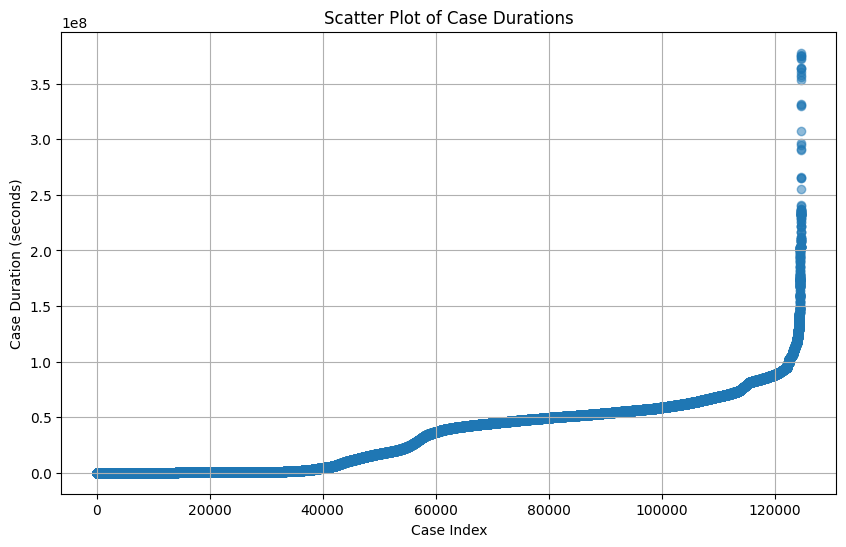

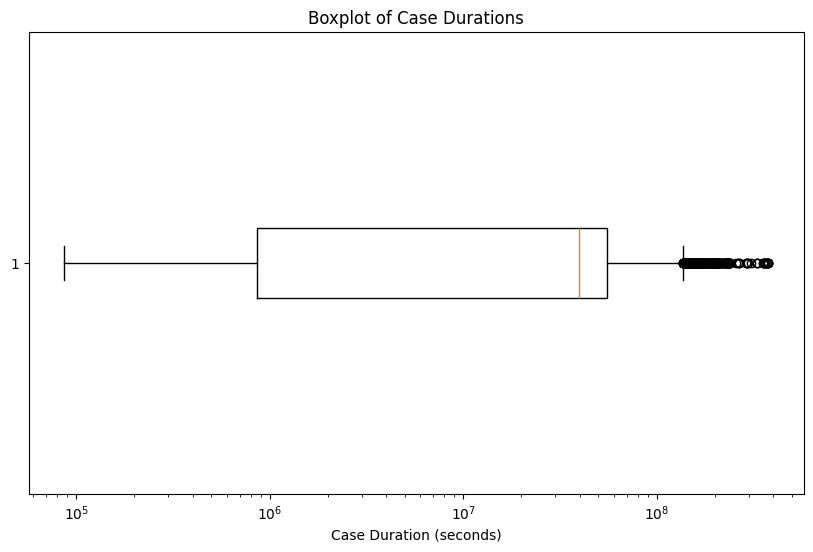

In [15]:
case_durations = pm4py.get_all_case_durations(filtered_log)

# Convertire le durate dei casi in un DataFrame
df_case_durations = pd.DataFrame(case_durations, columns=['duration'])

# Calcolare le statistiche
mean_duration = df_case_durations['duration'].mean()
max_duration = df_case_durations['duration'].max()
min_duration = df_case_durations['duration'].min()
std_duration = df_case_durations['duration'].std()
quantiles_duration = df_case_durations['duration'].quantile([0.25, 0.5, 0.75])

# Stampare le statistiche
print(f"Mean Duration: {mean_duration}")
print(f"Max Duration: {max_duration}")
print(f"Min Duration: {min_duration}")
print(f"Std Duration: {std_duration}")
print(f"Quantiles Duration:\n{quantiles_duration}")

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_case_durations.index, df_case_durations['duration'], alpha=0.5)
plt.xlabel('Case Index')
plt.ylabel('Case Duration (seconds)')
plt.title('Scatter Plot of Case Durations')
plt.grid(True)
plt.show()

#boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df_case_durations['duration'], vert=False)
plt.xlabel('Case Duration (seconds)')
plt.title('Boxplot of Case Durations')
plt.xscale('log')
plt.show()

col_0                   count
category                     
Less than a day          5506
Less than a week        23048
Less than two weeks      5137
Less than a month        3534
Less than two months     3229
Less than three months   2226
Less than six months     5021
Less than 12 months      9255
Less than 18 months     11160
Less than 24 months     30935
Less than five years    25376
More than                 243


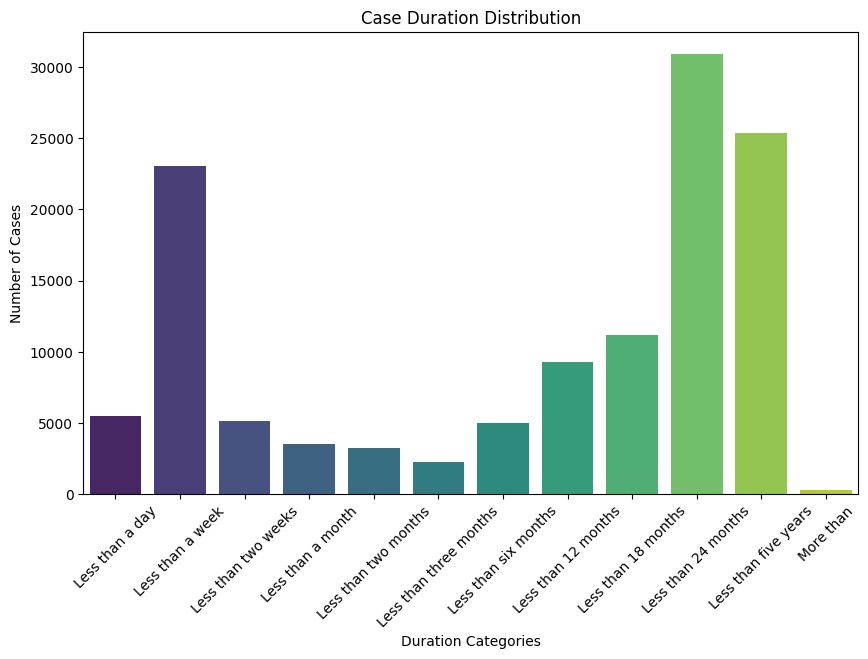

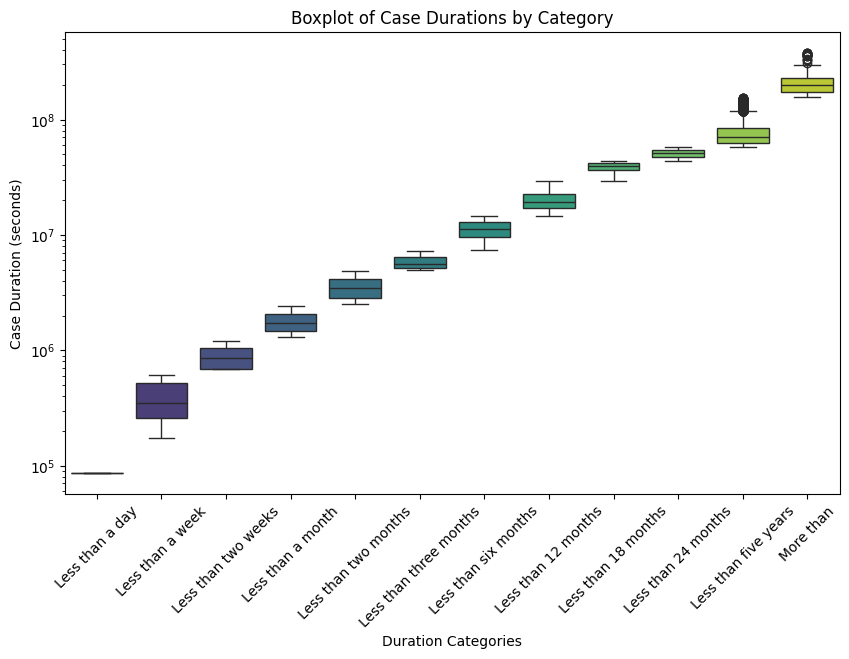

In [53]:
## Visualize durations
day = 24 * 3600
week = 7 * day
month = 4 * week

categories = {
    'Less than a day': day,
    'Less than a week': week,
    'Less than two weeks': 2 * week,
    'Less than a month': month,
    'Less than two months': 2 * month,
    'Less than three months': 3 * month,
    'Less than six months': 6 * month,
    'Less than 12 months': 12 * month,
    'Less than 18 months': 18 * month,
    'Less than 24 months': 24 * month,
    'Less than five years': 5 * 12 * 30 * 24 * 3600,
    'More than': float('inf')
}


# Categorize case durations
def categorize_duration(duration):
    for category, max_duration in categories.items():
        if duration <= max_duration:
            return category
    return 'More than'

df_durations = pd.DataFrame({'case_duration': case_durations})
df_durations['category'] = df_durations['case_duration'].apply(categorize_duration)

# Create cross table
cross_table = pd.crosstab(index=df_durations['category'], columns='count')
cross_table = cross_table.reindex(categories.keys(), fill_value=0)

# Print the cross table
print(cross_table)

# Plot the distribution
plt.figure(figsize=(10, 6))

sns.countplot(data=df_durations, x='category', order=categories.keys(), palette='viridis', hue='category')
plt.xlabel('Duration Categories')
plt.ylabel('Number of Cases')
plt.title('Case Duration Distribution')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_durations, x='category', y='case_duration', order=categories.keys(), palette='viridis', hue='category')
plt.xlabel('Duration Categories')
plt.ylabel('Case Duration (seconds)')
plt.title('Boxplot of Case Durations by Category')
plt.xticks(rotation=45)
plt.yscale('log')  # Use a logarithmic scale to better manage the differences in duration
plt.show()


# Divide log
* Paid and unPaid

In [17]:
import random
att_finali2 = ['Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge']

logPaid = pm4py.filter_end_activities(filtered_log, ['Payment'] )
logUnPaid = pm4py.filter_end_activities(filtered_log, att_finali2)
#-----

logPaid.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,terminate
7,36.0,561,NP,Create Fine,A,0.0,complete,2007-03-09 00:00:00+00:00,157.0,0.0,A10000,0.0,NaN,NaN,0.0,No
8,13.0,NaN,MV,Send Fine,NaN,0.0,complete,2007-07-17 00:00:00+00:00,NaN,NaN,A10000,13.0,NaN,NaN,0.0,No
9,0.0,NaN,MV,Insert Fine Notification,NaN,0.0,complete,2007-08-02 00:00:00+00:00,NaN,NaN,A10000,0.0,P,P,0.0,No
10,74.0,NaN,MV,Add penalty,NaN,0.0,complete,2007-10-01 00:00:00+00:00,NaN,NaN,A10000,0.0,NaN,NaN,0.0,No
11,87.0,NaN,MV,Payment,NaN,87.0,complete,2008-09-09 00:00:00+00:00,NaN,NaN,A10000,0.0,NaN,NaN,87.0,No


In [18]:
# to see random case:concept:name
ls_logPaid = logPaid['case:concept:name'].unique()
logPaid[logPaid['case:concept:name'] == ls_logPaid[random.randint(0, len(ls_logPaid))]]


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,terminate
286725,71.0,48,NP,Create Fine,A,0.0,complete,2005-08-09 00:00:00+00:00,158.0,0.0,S105247,0.0,NaN,NaN,0.0,No
286726,71.0,NaN,MV,Payment,NaN,71.0,complete,2005-08-10 00:00:00+00:00,NaN,NaN,S105247,0.0,NaN,NaN,71.0,No


In [19]:
#Statistical Analysis
#I valori restituiti sono in secondi
import time
def secondToTimeFormat(sec: int):
    ls = [60,60,24,7,30,12]
    udm =['s','m','h','g','w','y']
    res =''
    
    for l,u in zip(ls,udm):
        res =  str(int(sec)%l) + u + ':' + res
        sec = sec / l
        if int(sec) == 0:
            break 
    return res[0:-1]



meanDuration_logPaid = np.mean((pm4py.get_all_case_durations(logPaid)))
stdDuration_logPaid = np.std((pm4py.get_all_case_durations(logPaid)))

meanDuration_logUnPaid = np.mean((pm4py.get_all_case_durations(logUnPaid)))
stdDuration_logUnPaid = np.std((pm4py.get_all_case_durations(logUnPaid)))

print('logPaid')
print(f'mean: \t{secondToTimeFormat(meanDuration_logPaid)}')
print(f'std: \t{secondToTimeFormat(stdDuration_logPaid)}')

print('logUnPaid')
print(f'mean: \t{secondToTimeFormat(meanDuration_logUnPaid)}')
print(f'std: \t{secondToTimeFormat(stdDuration_logUnPaid)}')

logPaid
mean: 	16w:3g:13h:27m:43s
std: 	27w:1g:12h:59m:51s
logUnPaid
mean: 	3y:6w:4g:12h:46m:7s
std: 	1y:5w:2g:19h:4m:43s


In [20]:
#2: Analisi delle Durate di Processo

case_durations_logPaid = pm4py.get_all_case_durations(logPaid)

case_durations_logUnPaid = pm4py.get_all_case_durations(logUnPaid)


col_0                   count
category                     
Less than a day          5506
Less than a week        23048
Less than two weeks      5137
Less than a month        3534
Less than two months     3225
Less than three months   2150
Less than six months     4127
Less than 12 months      7437
Less than 18 months      4268
Less than 24 months      2477
Less than five years     1489
More than                   1


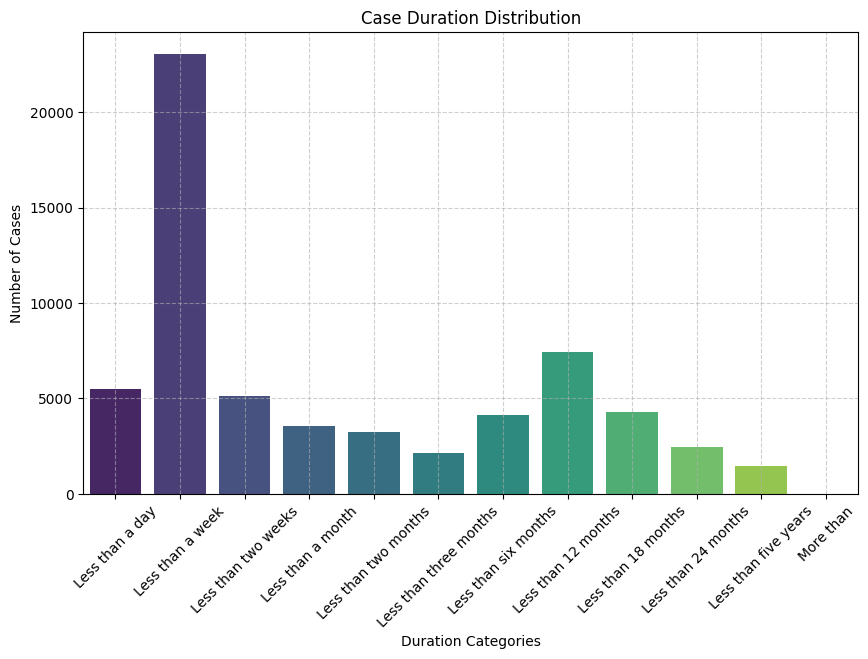

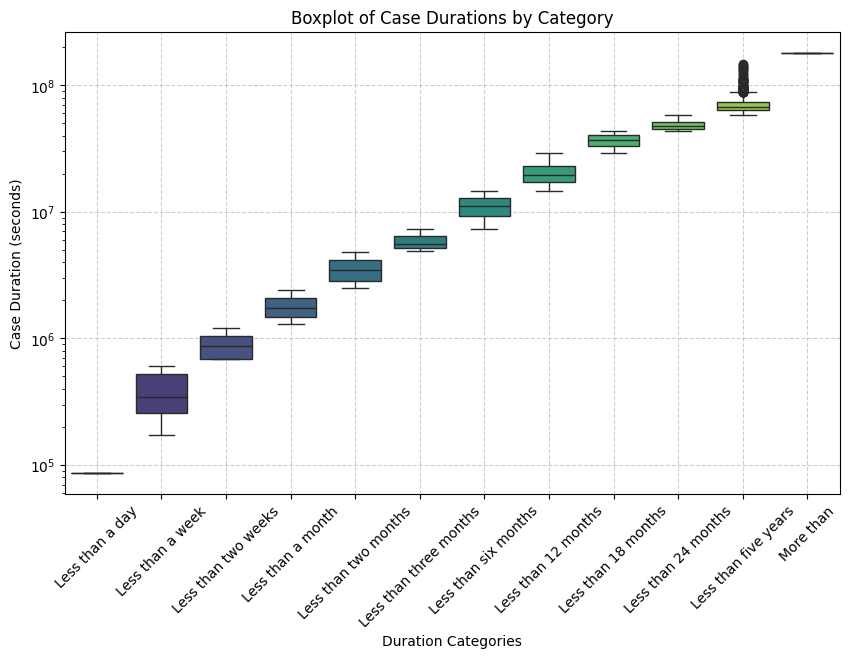

In [55]:
#Plot histograms and boxplots for case durations and payment amounts in both datasets.

df_durations_logPaid = pd.DataFrame({'case_duration': case_durations_logPaid})
df_durations_logPaid['category'] = df_durations_logPaid['case_duration'].apply(categorize_duration)

# Create cross table
cross_table = pd.crosstab(index=df_durations_logPaid['category'], columns='count')
cross_table = cross_table.reindex(categories.keys(), fill_value=0)

# Print the cross table
print(cross_table)

# Plot the distribution
plt.figure(figsize=(10, 6))

sns.countplot(data=df_durations_logPaid, x='category', order=categories.keys(), palette='viridis', hue='category')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Duration Categories')
plt.ylabel('Number of Cases')
plt.title('Case Duration Distribution')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_durations_logPaid, x='category', y='case_duration', order=categories.keys(), palette='viridis', hue='category')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Duration Categories')
plt.ylabel('Case Duration (seconds)')
plt.title('Boxplot of Case Durations by Category')
plt.xticks(rotation=45)
plt.yscale('log')  # Use a logarithmic scale to better manage the differences in duration
plt.show()


col_0                   count
category                     
Less than a day             0
Less than a week            0
Less than two weeks         0
Less than a month           0
Less than two months        4
Less than three months     76
Less than six months      894
Less than 12 months      1818
Less than 18 months      6892
Less than 24 months     28458
Less than five years    23887
More than                 242


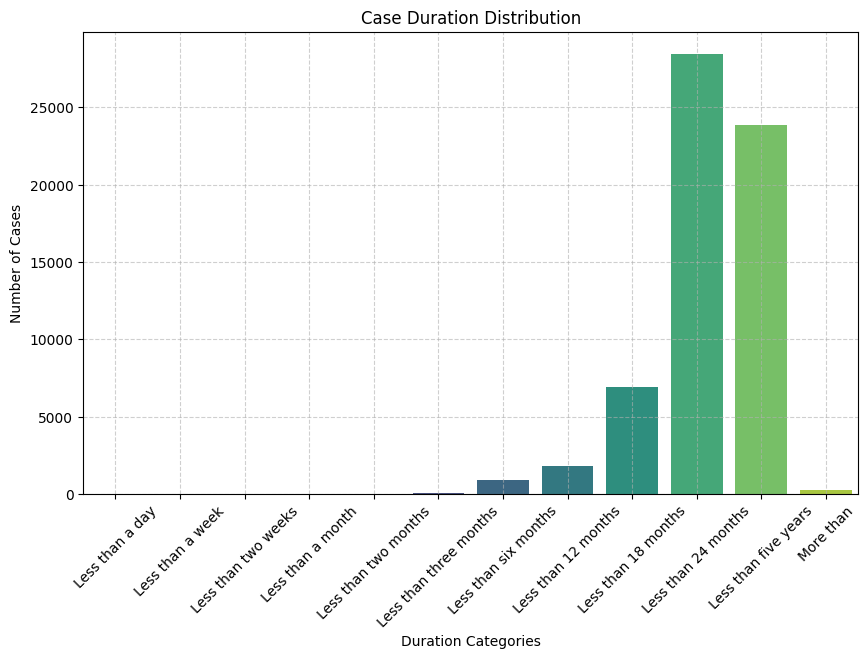

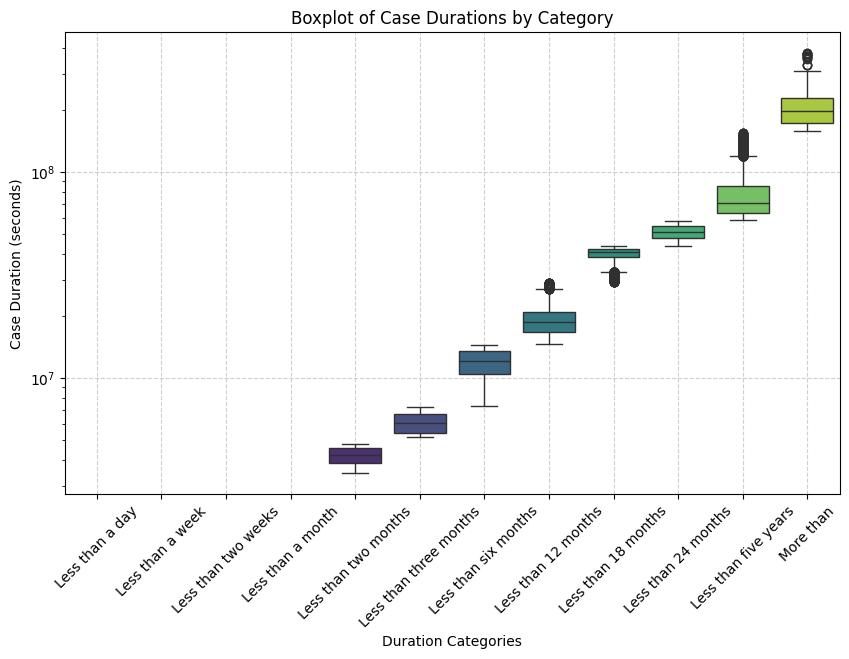

In [54]:
#Plot histograms and boxplots for case durations and payment amounts in both datasets.

df_durations_logUnPaid = pd.DataFrame({'case_duration': case_durations_logUnPaid})
df_durations_logUnPaid['category'] = df_durations_logUnPaid['case_duration'].apply(categorize_duration)

# Create cross table
cross_table = pd.crosstab(index=df_durations_logUnPaid['category'], columns='count')
cross_table = cross_table.reindex(categories.keys(), fill_value=0)

# Print the cross table
print(cross_table)

# Plot the distribution
plt.figure(figsize=(10, 6))

sns.countplot(data=df_durations_logUnPaid, x='category', order=categories.keys(), palette='viridis', hue='category')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Duration Categories')
plt.ylabel('Number of Cases')
plt.title('Case Duration Distribution')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_durations_logUnPaid, x='category', y='case_duration', order=categories.keys(), palette='viridis', hue='category')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Duration Categories')
plt.ylabel('Case Duration (seconds)')
plt.title('Boxplot of Case Durations by Category')
plt.xticks(rotation=45)
plt.yscale('log')  # Use a logarithmic scale to better manage the differences in duration
plt.show()

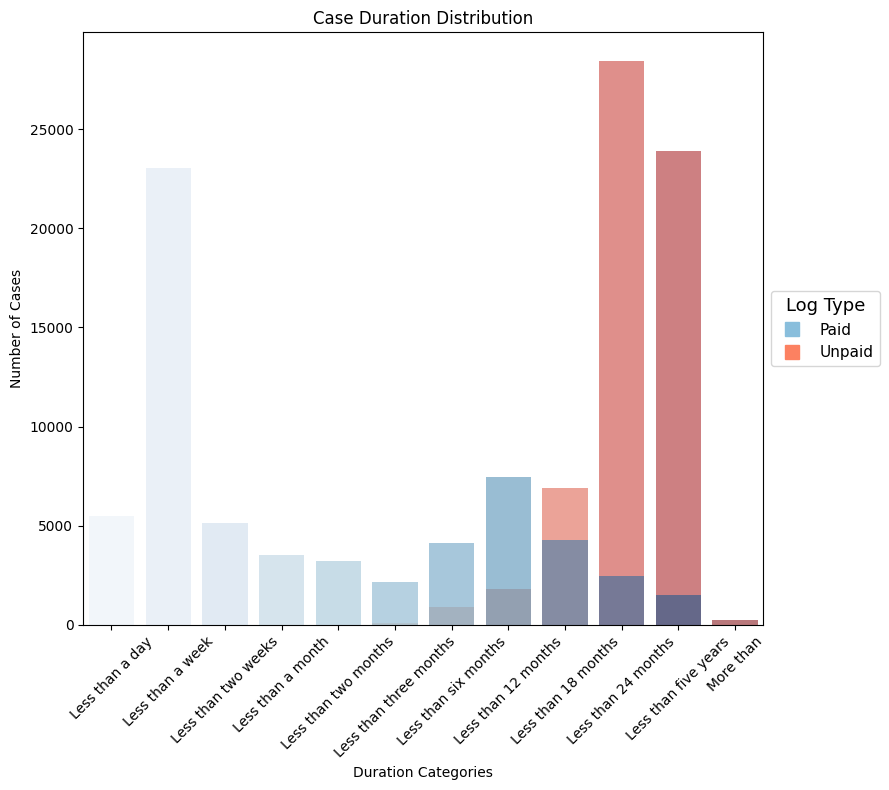

In [26]:
import matplotlib.lines as mlines
# Create a figure
plt.figure(figsize=(12, 8))

# Overlay the first histogram (red)
sns.countplot(data=df_durations_logUnPaid, x='category', order=categories.keys(), palette='Reds', hue='category', alpha=0.6)

# Overlay the second histogram (blue) using the same x-axis
sns.countplot(data=df_durations_logPaid, x='category', order=categories.keys(), palette='Blues', hue='category', alpha=0.6)

# Add labels and title
plt.xlabel('Duration Categories')
plt.ylabel('Number of Cases')
plt.title('Case Duration Distribution')
plt.xticks(rotation=45)

# Create custom handlers for the legend with the palette colors
blue_patch = mlines.Line2D([], [], color=sns.color_palette('Blues').as_hex()[2], marker='s', linestyle='None', markersize=10, label='Paid')
red_patch = mlines.Line2D([], [], color=sns.color_palette('Reds').as_hex()[2], marker='s', linestyle='None', markersize=10, label='Unpaid')

# Display an improved legend externally
plt.legend(handles=[blue_patch, red_patch], title='Log Type', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize='13', fontsize='11')

# Optimize layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Increase right margin for legend space

# Show the plot
plt.show()


# T-test

T-statistic: 9.928369333950219, P-value: 3.3586386693449295e-23


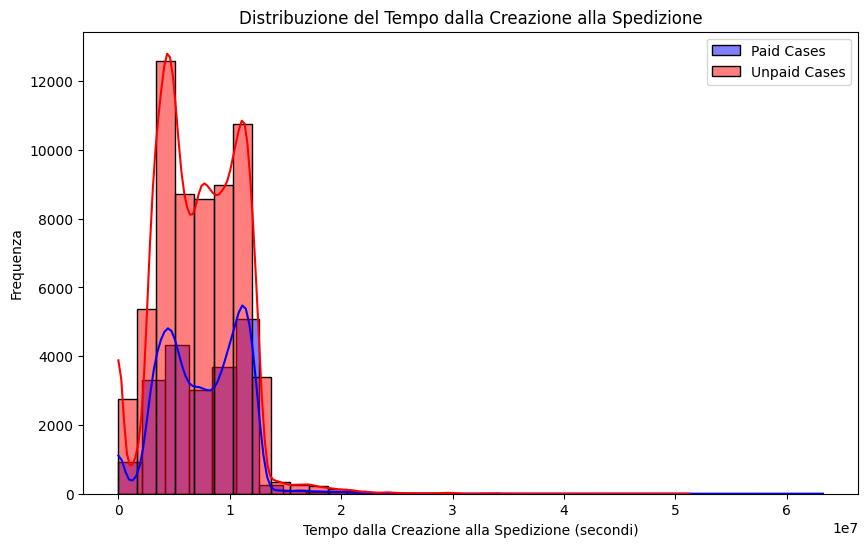

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per calcolare il tempo dalla creazione alla spedizione
def calculate_create_to_send_time(log):
    create_times = log[log['concept:name'] == 'Create Fine'].set_index('case:concept:name')['time:timestamp']
    send_times = log[log['concept:name'] == 'Send Fine'].set_index('case:concept:name')['time:timestamp']
    
    create_to_send = (send_times - create_times).dropna().dt.total_seconds()
    
    return create_to_send

# Calcolo del tempo dalla creazione alla spedizione per logPaid e logUnPaid
create_to_send_paid = calculate_create_to_send_time(logPaid)
create_to_send_unpaid = calculate_create_to_send_time(logUnPaid)

# Confronto tra casi pagati e non pagati
t_stat, p_val = ttest_ind(create_to_send_paid, create_to_send_unpaid, equal_var=False)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

# Visualizzazione
plt.figure(figsize=(10, 6))
sns.histplot(create_to_send_paid, bins=30, color='blue', kde=True, label='Paid Cases')
sns.histplot(create_to_send_unpaid, bins=30, color='red', kde=True, label='Unpaid Cases')
plt.xlabel('Tempo dalla Creazione alla Spedizione (secondi)')
plt.ylabel('Frequenza')
plt.title('Distribuzione del Tempo dalla Creazione alla Spedizione')
plt.legend()
plt.show()


The T-statistic and P-value values obtained from the t-test analysis are highly significant and can be interpreted as follows:

Conclusions from the T-test Results
T-statistic: 9.928

A T-statistic as high as 9.928 indicates that there is a large difference between the average creation and dispatch times for paid and unpaid cases. The higher the value of the T-statistic, the greater the difference between the groups in terms of mean.
P-value: 3.358e-23

A P-value of 3.358e-23 (which is much smaller than 0.05) suggests that the probability of observing such a large difference between the groups simply by chance is extremely low. This very high level of significance indicates that we can reject the null hypothesis (that there is no difference between the groups) with high confidence.Interpretation and Implications
Significant Difference:

The difference between the average creation and shipment times for paid and unpaid cases is highly significant. This means that the timing between the creation and dispatch of the fine has a significant effect on the payment outcome.
Impact of Timing:

Your hypothesis that the time from the creation of the fine to its shipment is a critical factor in determining payment success seems to be validated. Paid cases tend to have a different time interval between these two activities than unpaid cases.
Actions and Recommendations.
Optimizing Timing:


Based on these results, you can recommend optimizing the process of sending fines, reducing the time from creation to dispatch. It may be helpful to establish procedures or standards to ensure that fines are mailed as quickly as possible after they are created.Process Monitoring:

Implement a monitoring system to continuously track and analyze these times. This could help to quickly identify any delays and take immediate corrective action.





In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Funzione per calcolare la durata tra "Create Fine" e "Send Fine"
def calculate_create_to_send_time(log):
    create_times = log[log['concept:name'] == 'Create Fine'].set_index('case:concept:name')['time:timestamp']
    send_times = log[log['concept:name'] == 'Send Fine'].set_index('case:concept:name')['time:timestamp']
    create_to_send = (send_times - create_times).dropna().dt.total_seconds()
    return create_to_send.to_dict()

# Supponendo che logPaid e logUnPaid siano i tuoi dataframe
create_to_send_logPaid = calculate_create_to_send_time(logPaid)
create_to_send_logUnPaid = calculate_create_to_send_time(logUnPaid)

# Creazione dei dataframe con le durate e la variabile target (successo del pagamento)
df_logPaid = pd.DataFrame(list(create_to_send_logPaid.items()), columns=['case:concept:name', 'create_to_send'])
df_logPaid['payment_success'] = 1

df_logUnPaid = pd.DataFrame(list(create_to_send_logUnPaid.items()), columns=['case:concept:name', 'create_to_send'])
df_logUnPaid['payment_success'] = 0

# Unione dei due dataframe
df = pd.concat([df_logPaid, df_logUnPaid], ignore_index=True)

# Controllo e rimozione di valori mancanti o infiniti
print(df.isnull().sum())  # Controllo dei valori nulli
print(df.isin([float('inf'), -float('inf')]).sum())  # Controllo dei valori infiniti

# Rimozione delle righe con valori mancanti o infiniti
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Aggiunta della costante per la regressione
X = sm.add_constant(df['create_to_send'])  # Aggiunta del termine costante

# Modello di regressione lineare
model = sm.OLS(df['payment_success'], X).fit()

# Risultati del modello
print(model.summary())

# Verifica delle prime righe del dataframe per assicurarsi che tutto sia corretto
print(df.head())


# Botteneck
## Paid

/var/folders/yl/_wwlxybd1pxg7mgrkyjdtsz00000gp/T/ipykernel_9759/1828306616.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_durations.index, y=activity_durations.values, palette='viridis')


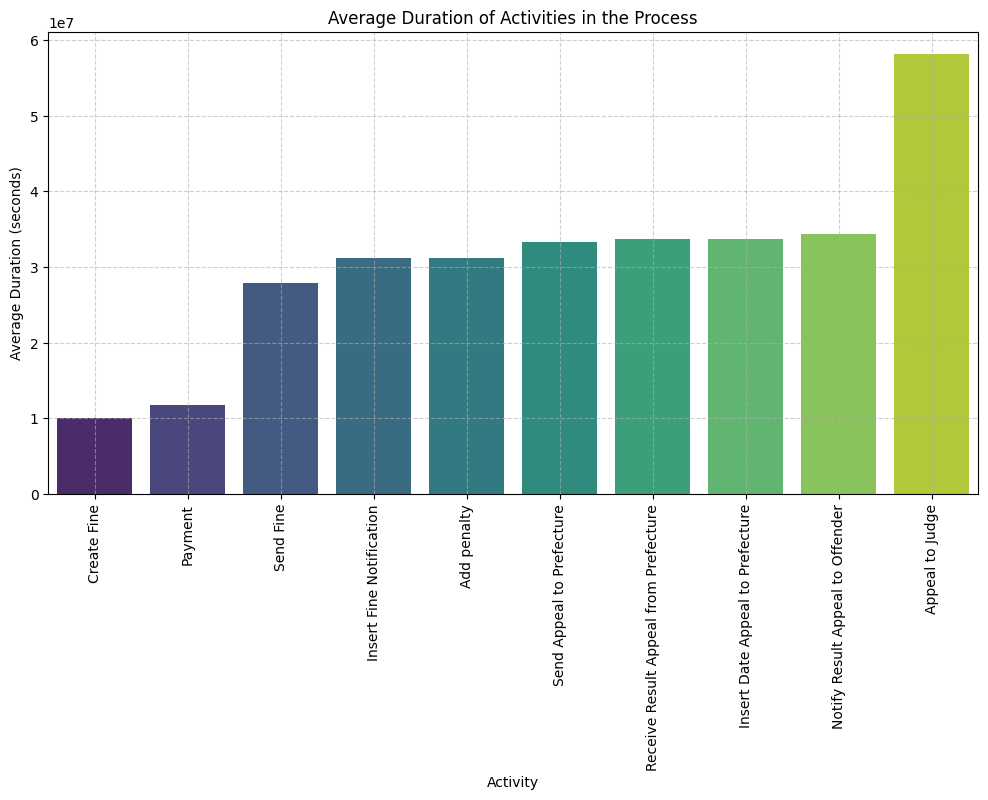

In [48]:
log = pd.DataFrame(logPaid)
# Assuming 'log' is the DataFrame with event data
# Calculate the duration for each activity
log['duration'] = log.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min()).dt.total_seconds()

# Calculate the average durations per activity
activity_durations = log.groupby('concept:name')['duration'].mean().sort_values()

# Visualize the average duration per activity
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_durations.index, y=activity_durations.values, palette='viridis')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Activity')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration of Activities in the Process')
plt.xticks(rotation=90)
plt.show()


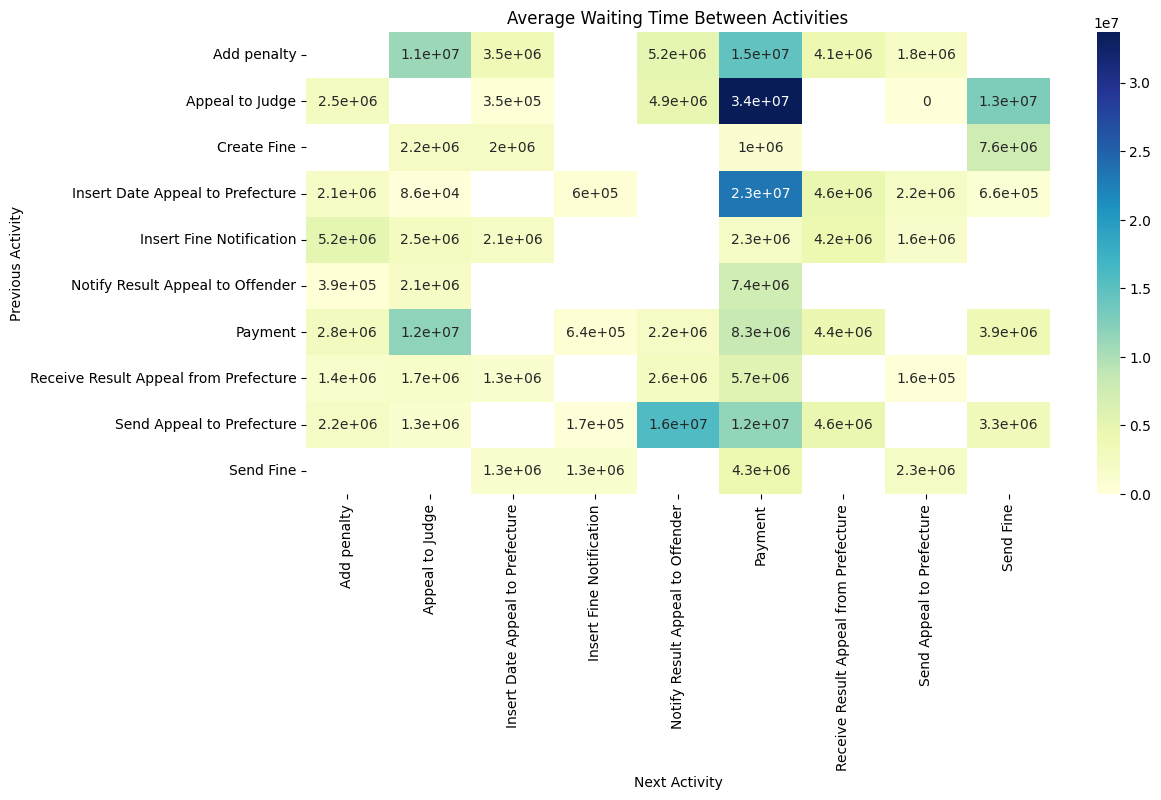

In [29]:
# Calculate the waiting times between activities
log['next_activity'] = log.groupby('case:concept:name')['concept:name'].shift(-1)
log['time_diff'] = (log.groupby('case:concept:name')['time:timestamp'].shift(-1) - log['time:timestamp']).dt.total_seconds()

# Filter only the rows where there is a next activity
wait_times = log[log['next_activity'].notnull()]

# Calculate the average waiting times for activity pairs
wait_time_analysis = wait_times.groupby(['concept:name', 'next_activity'])['time_diff'].mean().unstack()

# Visualize the waiting time analysis
plt.figure(figsize=(12, 6))
sns.heatmap(wait_time_analysis, cmap='YlGnBu', annot=True)
plt.xlabel('Next Activity')
plt.ylabel('Previous Activity')
plt.title('Average Waiting Time Between Activities')
plt.show()


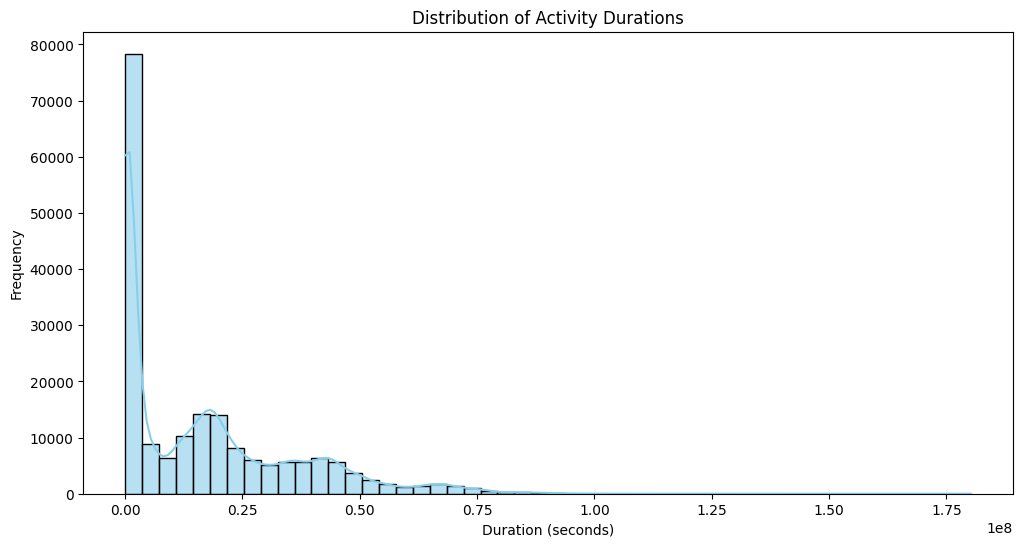

/var/folders/yl/_wwlxybd1pxg7mgrkyjdtsz00000gp/T/ipykernel_9759/2174518337.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='concept:name', y='duration', data=log,


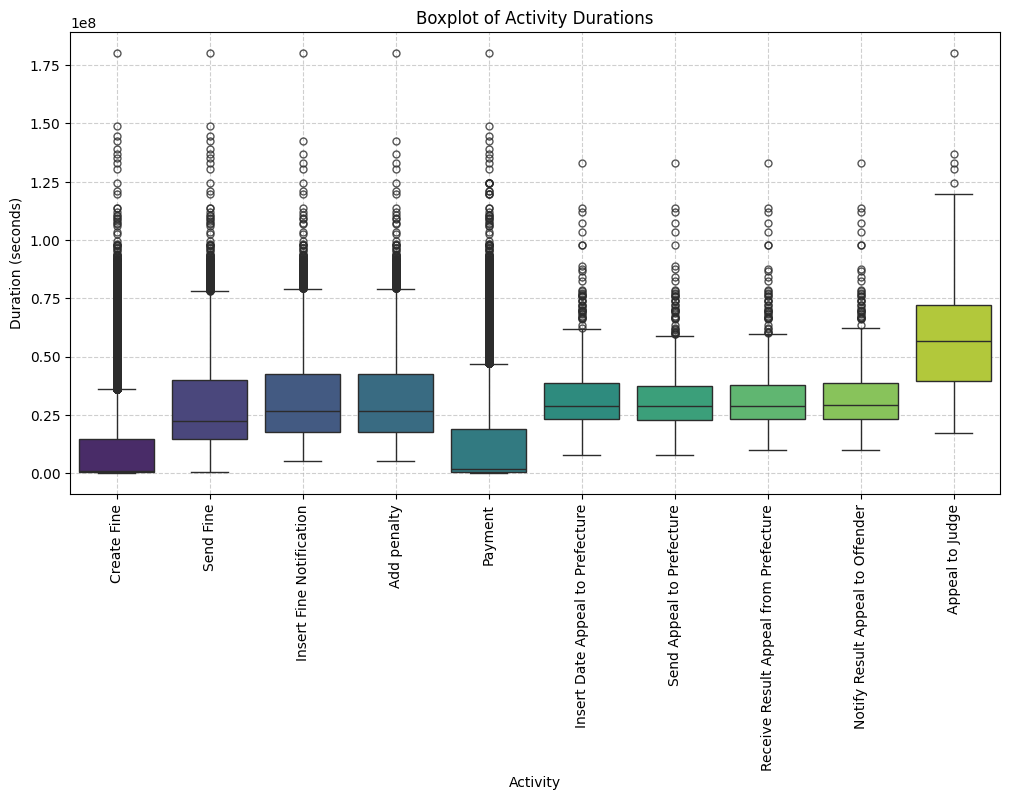

In [49]:
# Visualize the distribution of activity durations
plt.figure(figsize=(12, 6))
sns.histplot(log['duration'], bins=50, kde=True, color='skyblue', alpha=0.6, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Durations')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='concept:name', y='duration', data=log, 
            flierprops=dict(marker='o', color='red', markersize=5, alpha=0.8), # Outlier settings
            palette='viridis')  # Change color palette for better visibility
plt.xlabel('Activity')
plt.ylabel('Duration (seconds)')
plt.title('Boxplot of Activity Durations')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.show()


## unPaid

/var/folders/yl/_wwlxybd1pxg7mgrkyjdtsz00000gp/T/ipykernel_9759/4166724263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_durations.index, y=activity_durations.values, palette='viridis')


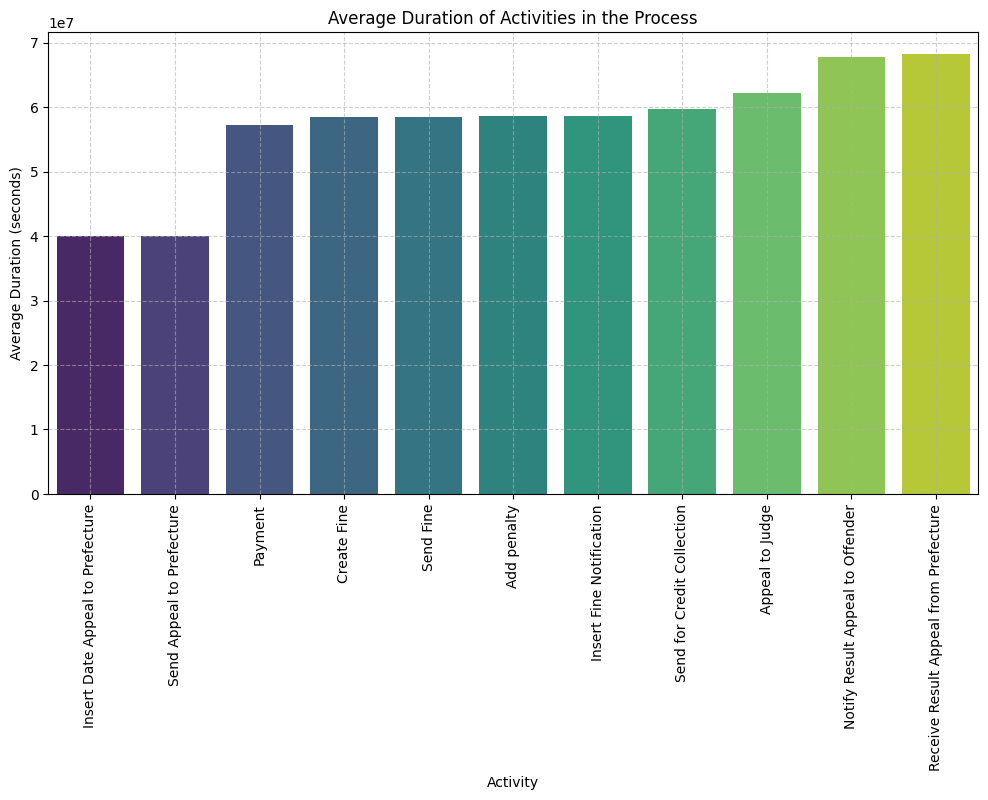

In [45]:
# Unpaid
log = pd.DataFrame(logUnPaid)
# Assuming 'log' is the DataFrame with event data
# Calculate the duration for each activity
log['duration'] = log.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min()).dt.total_seconds()

# Calculate the average durations per activity
activity_durations = log.groupby('concept:name')['duration'].mean().sort_values()

# Visualize the average duration per activity
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_durations.index, y=activity_durations.values, palette='viridis')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Activity')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration of Activities in the Process')
plt.xticks(rotation=90)
plt.show()


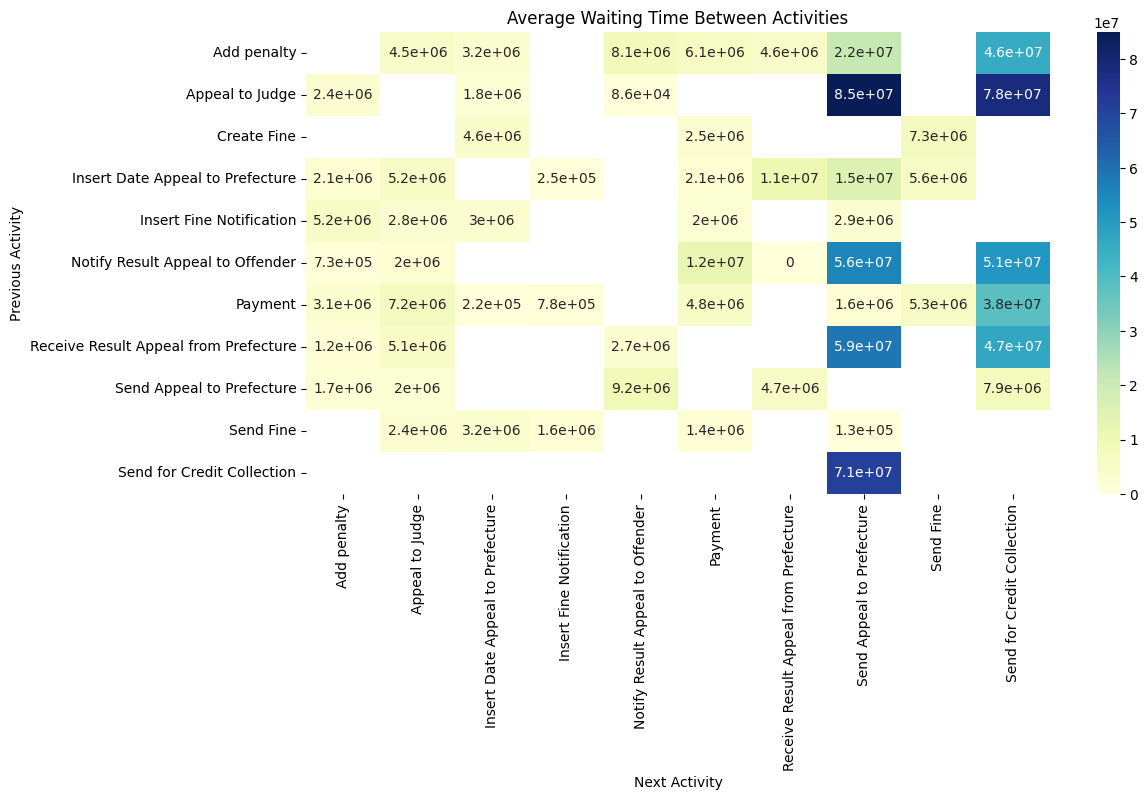

In [46]:
# Calculate the waiting times between activities
log['next_activity'] = log.groupby('case:concept:name')['concept:name'].shift(-1)
log['time_diff'] = (log.groupby('case:concept:name')['time:timestamp'].shift(-1) - log['time:timestamp']).dt.total_seconds()

# Filter only the rows where there is a next activity
wait_times = log[log['next_activity'].notnull()]

# Calculate the average waiting times for activity pairs
wait_time_analysis = wait_times.groupby(['concept:name', 'next_activity'])['time_diff'].mean().unstack()

# Visualize the waiting time analysis
plt.figure(figsize=(12, 6))
sns.heatmap(wait_time_analysis, cmap='YlGnBu', annot=True)
plt.xlabel('Next Activity')
plt.ylabel('Previous Activity')
plt.title('Average Waiting Time Between Activities')
plt.show()


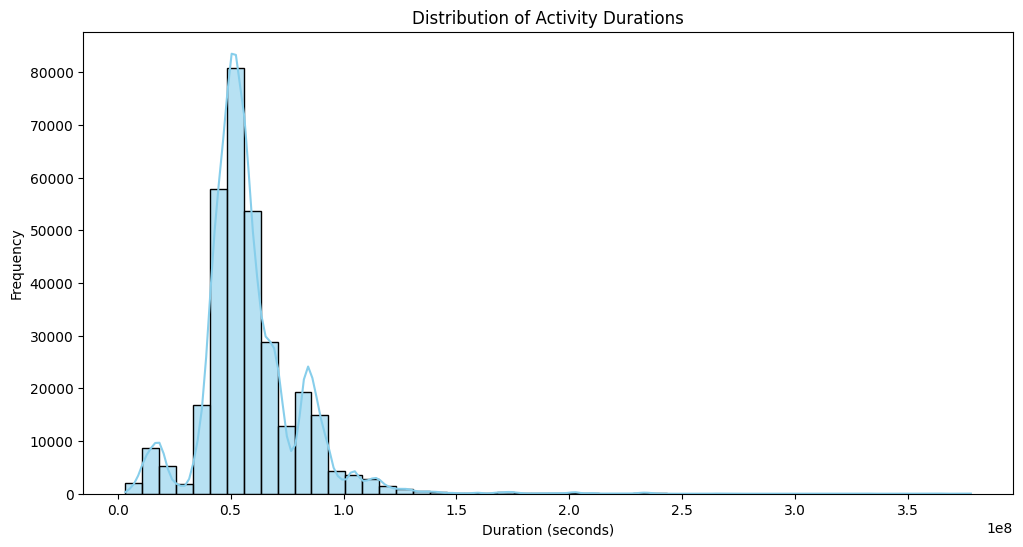

/var/folders/yl/_wwlxybd1pxg7mgrkyjdtsz00000gp/T/ipykernel_9759/2174518337.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='concept:name', y='duration', data=log,


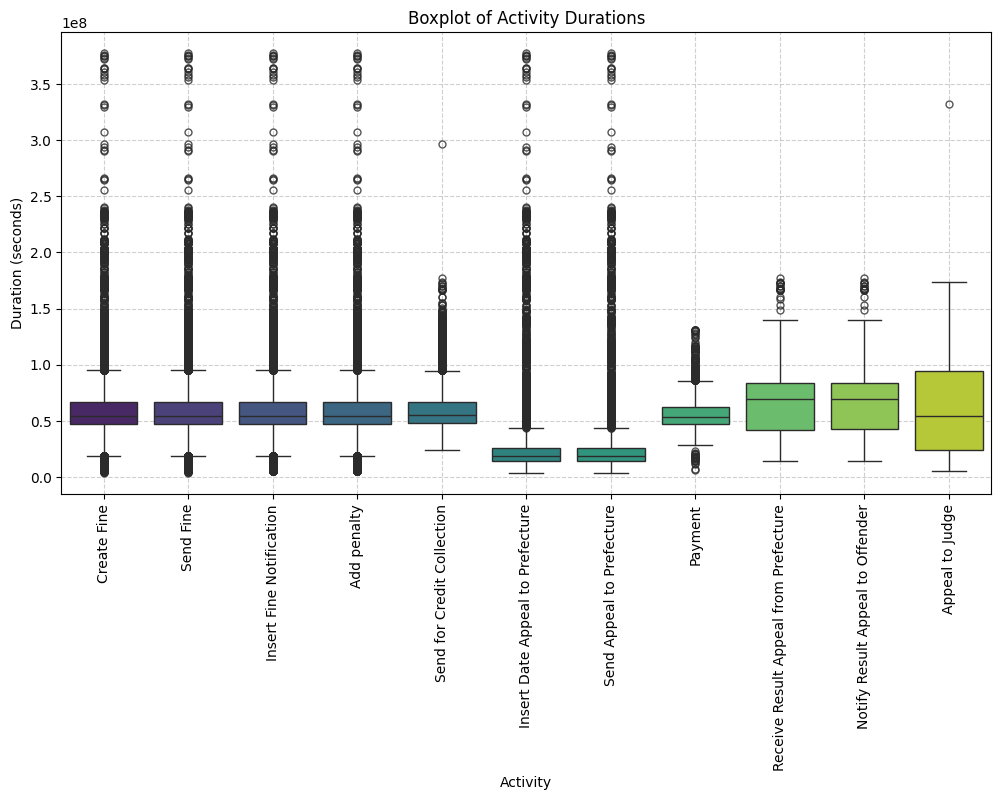

In [47]:
# Visualize the distribution of activity durations
plt.figure(figsize=(12, 6))
sns.histplot(log['duration'], bins=50, kde=True, color='skyblue', alpha=0.6, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Durations')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='concept:name', y='duration', data=log, 
            flierprops=dict(marker='o', color='red', markersize=5, alpha=0.8), # Outlier settings
            palette='viridis')  # Change color palette for better visibility
plt.xlabel('Activity')
plt.ylabel('Duration (seconds)')
plt.title('Boxplot of Activity Durations')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.show()


---

# PD
## paid


In [ ]:
# PM
top5_logPaid = pm4py.filter_variants_top_k(logPaid, 5)
net, im, fm = pm4py.discover_petri_net_inductive(top5_logPaid, noise_threshold=.4)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top1_logPaid = pm4py.filter_variants_top_k(logPaid, 1)
net, im, fm = pm4py.discover_petri_net_inductive(top1_logPaid, noise_threshold=.4)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top2_logPaid = pm4py.filter_variants_top_k(logPaid, 2)
net, im, fm = pm4py.discover_petri_net_inductive(top2_logPaid, noise_threshold=.4)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top3_logPaid = pm4py.filter_variants_top_k(logPaid, 3)
net, im, fm = pm4py.discover_petri_net_inductive(top3_logPaid, noise_threshold=.8)
pm4py.view_petri_net(net,im, fm, format='png')

## unPaid

In [ ]:
top5_logUnPaid = pm4py.filter_variants_top_k(logUnPaid, 5)
net, im, fm = pm4py.discover_petri_net_inductive(top5_logUnPaid, noise_threshold=.6)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top1_logUnPaid = pm4py.filter_variants_top_k(logUnPaid, 1)
net, im, fm = pm4py.discover_petri_net_inductive(top1_logUnPaid, noise_threshold=.6)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top2_logUnPaid = pm4py.filter_variants_top_k(logUnPaid, 2)
net, im, fm = pm4py.discover_petri_net_inductive(top2_logUnPaid, noise_threshold=.6)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
top3_logUnPaid = pm4py.filter_variants_top_k(logUnPaid, 3)
net, im, fm = pm4py.discover_petri_net_inductive(top3_logUnPaid, noise_threshold=.6)
pm4py.view_petri_net(net,im, fm, format='png')

## Conformance

In [ ]:
combined_log = pd.concat([top5_logUnPaid, top5_logPaid], ignore_index=True)

net, im, fm = pm4py.discover_petri_net_inductive(combined_log, noise_threshold=.3)
pm4py.view_petri_net(net,im, fm, format='png')

In [ ]:
# Conformance
diagnostics = pm4py.conformance_diagnostics_alignments(filtered_log , net , im, fm, return_diagnostics_dataframe=True)
diagnostics_df = pd.DataFrame.from_dict(diagnostics)

# Creazione dei bins di 0.05
bins = np.arange(0, 1.05, 0.05)
labels = [f"{round(b, 2)}-{round(b+0.05, 2)}" for b in bins[:-1]]
diagnostics_df['fitness_bin'] = pd.cut(diagnostics_df['fitness'], bins=bins, labels=labels, right=False)

# Creare una tabella pivot per contare le occorrenze di ciascun bin di fitness
pivot_table_bins = pd.pivot_table(diagnostics_df, index='fitness_bin', aggfunc='size', fill_value=0, observed=True)

# Calcolare la frequenza relativa
total_counts = pivot_table_bins.sum()
pivot_table_bins_relative = pivot_table_bins / total_counts

# Creare un DataFrame finale con la frequenza assoluta e relativa
result_df = pd.DataFrame({
    'absolute_frequency': pivot_table_bins,
    'relative_frequency': pivot_table_bins_relative
})

# Formattare la colonna delle frequenze relative come percentuali
result_df['relative_frequency'] = result_df['relative_frequency'].apply(lambda x: f"{x * 100:.2f}%")

print("Tabella pivot con frequenza assoluta e relativa per ciascun bin di fitness:")
print(result_df)